In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from classy            import Class
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

## Thin-shell clustering and Lyman Alpha Emitters

Let's look at some clustering properties of LAEs selected in narrow-band surveys.

A typical LAE at $z>2$ with $\sim L_\star$ Ly$\alpha$ luminosity is the counterpart of a local dwarf galaxy: a compact, metal-poor, star-forming galaxy with SFR$\sim 1-10\ M_\odot\mathrm{yr}^{-1}$.  Halo masses are very uncertain but range from 1e10 to 1e11Msun, though for the brighter galaxies we're interested in they may be closer to 1e12Msun.

From Table 1 of the ODIN proposal we have redshift widths of 0.06, 0.06 and 0.08 at z=2.4, 3.1 and 4.5 respectively.  Using $d\chi=c\, dz/H(z)$ these translate into comoving distance "depths" of 50, 40 and $30h^{-1}$Mpc.   These depths correspond to fundamental modes of $2\pi/\Delta\chi = 0.12$, 0.16 and $0.19\,h\,\mathrm{Mpc}^{-1}$ which is significantly larger than the spacing of the BAO peaks.

If we were to do a pseudo-$C_\ell$ analysis in redshift bins.  If I make the bins wide enough that redshift errors are "small" then I can treat these as disjoint projected fields.  The shells are so narrow that the Limber approximation is not valid for any interesting $k$, which is an odd feature we don't normally encounter.  Making the flat-sky approximation one finds the angular cross-spectrum between shells $i$ and $j$, each of width $\Delta\chi$ and separated by $\chi_{ij}$ is
$$
  C_\ell^{ij} \simeq \int\frac{dk_\parallel}{2\pi\,\chi^2}
  \ \cos[k_\parallel \chi_{ij}]
  \ j_0^2\left(\frac{k_\parallel \Delta\chi}{2}\right)
  \ P(k_\perp=\ell/\chi,k_\parallel)
$$
where $j_0(x)=\sin(x)/x$ is the spherical Bessel function of order 0 and $\chi$ is the comoving distance to the mean redshift.

We will use CLASS to compute the power spectra and distance-redshift relations, etc.

In [3]:
# Set up a default set of parameters.
params = {'output': 'tCl lCl mPk',
          'l_max_scalars': 3000,
          'lensing': 'yes',
          'P_k_max_h/Mpc': 50.,
          'non linear':'halofit', 
          'z_pk': '0.0,6',
          'A_s': 1.81e-9,
          'n_s': 0.9665,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 2.033,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02242,
          'omega_cdm': 0.11923,
          'Omega_k': 0.}
#
cosmo = Class() 
cosmo.set(params) 
cosmo.compute()
#
wb = cosmo.omega_b()
wnu= 0.0106 * params['m_ncdm']
#
print("OmegaM=",cosmo.Omega_m())
print("sigma8=",cosmo.sigma8())
print("hubble=",cosmo.h())
print("omegab=",wb)
print("omegav=",wnu)
#
cosmo.get_current_derived_parameters(['H0','Omega_Lambda',\
                                      'age','conformal_age','Neff',\
                                      'z_reio','100*theta_s','rs_rec','rs_d'])

OmegaM= 0.31046286816444985
sigma8= 0.7507748869468275
hubble= 0.677
omegab= 0.022420000000000002
omegav= 0.000636


{'H0': 67.7,
 'Omega_Lambda': 0.689458120355779,
 'age': 13.786368683292558,
 'conformal_age': 14167.998072801494,
 'Neff': 3.0461982214534324,
 'z_reio': 7.9087066650390625,
 '100*theta_s': 1.0419089178168865,
 'rs_rec': 144.68928096862328,
 'rs_d': 147.24447550725276}

In [4]:
# Compute the Zeldovich displacement and hence k_{nl}.
hub= cosmo.h() # To convert to "conventional" Mpc/h units.
kk = np.logspace(-3.5,0.3,250)
#
for zz in [2.0,2.5,3.0,3.5]:
    pk = np.array( [cosmo.pk(k*hub,zz)*hub**3 for k in kk] )
    pl = np.array( [cosmo.pk_lin(k*hub,zz)*hub**3 for k in kk] )
    #
    # Compute the Zeldovich displacement and hence k_{nl}.
    knl= 1/np.sqrt( np.trapz(pl,x=kk)/6./np.pi**2 )
    print("zz=",zz,", knl=",knl," h/Mpc.")
#

zz= 2.0 , knl= 0.4413542232221129  h/Mpc.
zz= 2.5 , knl= 0.5120101597613601  h/Mpc.
zz= 3.0 , knl= 0.5831897494106498  h/Mpc.
zz= 3.5 , knl= 0.6546696842130945  h/Mpc.


### The luminosity function and bias of LAEs

These are just Schechter fits taken from the literature, specifically [Konno+16](https://arxiv.org/abs/1512.01854).

In [5]:
# Schechter function fits from the literature.  The phi* definition
# is in terms of L, i.e. we need a ln(10) going to lgL [erg/s].
# phi* is in units of Mpc^{-3} and converted to Mpc/h below.
LFlist = []
LFlist.append({'zfid':2.2,'phis':3.37e-4,'Lstar':4.87e42,'alpha':-1.80,\
               'ref':'Konno+16'})
LFlist.append({'zfid':3.1,'phis':3.90e-4,'Lstar':8.49e42,'alpha':-1.80,\
               'ref':'Konno+16'})
LFlist.append({'zfid':3.7,'phis':3.31e-4,'Lstar':9.16e42,'alpha':-1.80,\
               'ref':'Konno+16'})

In [6]:
def nbar_fit(lgL,zz):
    """Computes nbar, in [Mpc/h]^{-3}, given line luminosity lgL [erg/s]
    for LAEs."""
    # Choose the closest redshift in the table.
    delz= np.array([np.abs(zz-lf['zfid']) for lf in LFlist])
    lf  = LFlist[np.argmin(delz)]
    # Get the Schechter paramerers, converting to Mpc/h units.
    hub = cosmo.h()
    phis,lgLstar,alpha = lf['phis']/hub**3,np.log10(lf['Lstar']),lf['alpha']
    # Just brute-force the Schechter integral, it's plenty fast enough.
    logl = np.linspace(lgL,lgLstar+10,1000)
    ll   = 10.0**(logl-lgLstar)
    lf   = np.log(10)*phis * ll**(alpha+1) * np.exp(-ll)
    nbar = np.trapz(lf,logl)
    return(nbar)

In [7]:
def bias_fit(lgL,zz):
    """The large-scale bias."""
    bb = 1.5+1.0*(lgL-42.)/0.5 # A placeholder for now.
    return(bb)
    #

We need to convert fluxes to luminosities.

In [8]:
def flux2L(zz):
    """Convert a flux in erg/s/cm2 to log10(L) in [erg/s].
    Add the returned value to log10(flux) to get log10(L)."""
    Mpc_cm = 3.086e24 # 1 Mpc in cm.
    dL     = cosmo.luminosity_distance(zz)
    val    = np.log10(4*np.pi)+2*(np.log10(dL)+np.log10(Mpc_cm))
    return(val)

In [9]:
# Just do a sanity check.
zz   = 3.1
flux = 5e-17
lgL  = np.log10(flux) + flux2L(zz)
#
print("z    ={:5.1f}".format(zz))
print("Flux ={:10.2e} [erg/s/cm^2]".format(flux))
print("lgL  ={:6.2f} [erg/s]".format(lgL))
print("nbar ={:10.2e}".format(nbar_fit(lgL,zz))+r' [Mpc/h]^3')
print("bias ={:5.1f}".format(bias_fit(lgL,zz)))

z    =  3.1
Flux =  5.00e-17 [erg/s/cm^2]
lgL  = 42.64 [erg/s]
nbar =  7.44e-04 [Mpc/h]^3
bias =  2.8


## Use a simple model for the power spectrum

We'll use a simple Kaiser+FoG model for the power spectrum.  We should really pre-compute and spline this or do some other kind of interpolation, but runtime isn't an issue for this exploratory work so we'll do it badly.

In [10]:
def pk2d(kpar,kperp,bb,sig,zz):
    """Returns the HaloFit P(kpar,kperp) at redshift zz for a
    tracer of bias bb with FoG sig."""
    hub= cosmo.h() # To convert to "conventional" Mpc/h units.
    ff = cosmo.scale_independent_growth_factor_f(zz)
    kk = np.sqrt(kpar**2 + kperp**2)
    mu = kpar/(kk+1e-30)
    pk = cosmo.pk(kk*hub,zz)*hub**3
    pk*= (bb+ff*mu**2)**2 * np.exp(-(kpar*sig)**2)
    return(pk)
#
def pkmu(kk,mu,bb,sig,zz):
    """Returns P(k,mu) at redshift zz for a tracer of bias bb with FoG sig."""
    hub= cosmo.h() # To convert to "conventional" Mpc/h units.
    ff = cosmo.scale_independent_growth_factor_f(zz)
    pk = cosmo.pk(kk*hub,zz)*hub**3
    pk*= (bb+ff*mu**2)**2 * np.exp(-(kk*mu*sig)**2)
    return(pk)

## Now let's make some plots.

First look at the integrand for $C_\ell$.

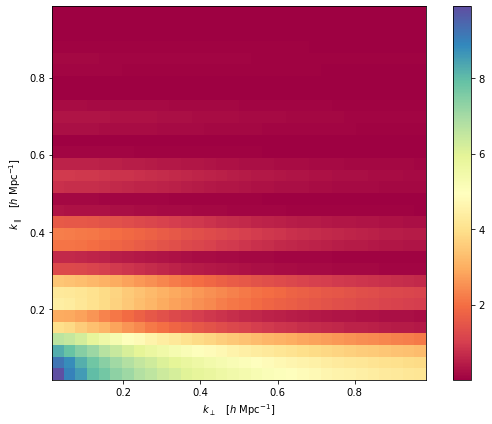

In [11]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
#
xx = (np.arange(32)+0.5) / 32.
yy = np.zeros( (xx.size,xx.size) )
#
ell = 1000 # Not used currently.
bb  = bias_fit(lgL,zz)
sig = 1.0  # Approximately 100km/s.
#
chi_ij = 0.0  # Shell separation (Mpc/h).
dchi   = 40.0 # Shell width (Mpc/h).
#
for i,kperp in enumerate(xx):
    for j,kpar in enumerate(xx):
        yy[i,j] = np.cos(kpar*chi_ij)
        yy[i,j]*= (np.sin(kpar*dchi/2)/(kpar*dchi/2))**2
        yy[i,j]*= pk2d(kpar,kperp,bb,sig,zz)
yy /= 2*np.pi
# Do an arcsinh scale.
scale = 1e-4*np.max(yy)
yy =  np.arcsinh(yy/scale)
cax = ax.imshow(yy.T,origin='lower',aspect='equal',cmap='Spectral',\
                extent=[xx[0],xx[-1],xx[0],xx[-1]])
fig.colorbar(cax,ax=ax)
#
#
ax.set_xlabel(r'$k_\perp\quad [h\ \mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$k_\parallel\quad [h\ \mathrm{Mpc}^{-1}]$')
#
plt.tight_layout()
#plt.savefig('thin_shell.png')

Text(0, 0.5, '$dC_\\ell/dk_\\parallel$')

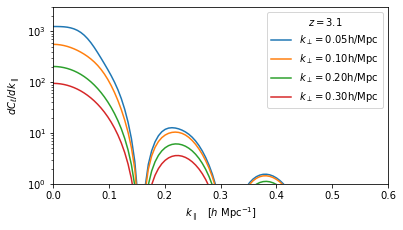

In [12]:
# Now let's look instead at the integrand in kpar at fixed ell or kperp.
#
bb  = bias_fit(lgL,zz)
sig = 1.0  # Approximately 100km/s.
#
chi_ij = 0.0  # Shell separation (Mpc/h).
dchi   = 40.0 # Shell width (Mpc/h).
#
Nk   = 150
kpar = np.linspace(1e-3,0.6,100)
#
fig,ax = plt.subplots(1,1,figsize=(6,3.25))
#
for j,kperp in enumerate([0.05,0.1,0.2,0.3]):
    yy = np.zeros_like(kpar)
    yy = np.cos(kpar*chi_ij)
    yy*=(np.sin(kpar*dchi/2)/(kpar*dchi/2))**2
    for i,kp in enumerate(kpar):
        yy[i]*= pk2d(kp,kperp,bb,sig,zz)
    yy /= 2*np.pi
    ax.plot(kpar,yy,color='C'+str(j),label=r'$k_\perp='+'{:.2f}$h/Mpc'.format(kperp))
#
ax.legend(title='$z={:.1f}$'.format(zz))
#
ax.set_xlim(0.0,0.6)
ax.set_ylim(1.0,3e3)
ax.set_yscale('log')
ax.set_xlabel(r'$k_\parallel\quad [h\ \mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$dC_\ell/dk_\parallel$')

## Angular clustering

### Angular power spectrum

The above makes sense if we have redshifts for each object and so can provide "tight" redshift bounds.  In the case where we have only $dN/dz$ however we need to replace the line-of-sight window function with a more general expression.  Assuming $\phi(\chi)$ is the normalized redshift distribution
$$
  C_\ell = \int_0^\infty\frac{dk_\parallel}{\pi \chi^2}
  \ P(k_\perp=\ell/\chi,k_\parallel)
  \ \int d\chi_1\,d\chi_2 \phi(\chi_1)\phi(\chi_2) \cos(k_\parallel[\chi_1-\chi_2])
$$
with $\chi=(1/2)(\chi_1+\chi_2)$.  We recognize the integral $d\chi_1\,d\chi_2$ as the square of the FT of $\phi$.  We can also massage this as
$$
  W^2(k_\parallel) = \int d\chi_1\,d\chi_2\ \phi(\chi_1)\phi(\chi_2)
  \cos(k_\parallel[\chi_1-\chi_2])
$$
or
$$
    \left[ \int d\chi\ \phi(\chi)\cos(k_\parallel[\chi-\chi_0]) \right]^2
  + \left[ \int d\chi\ \phi(\chi)\sin(k_\parallel[\chi-\chi_0]) \right]^2
$$
where $\chi_0$ is arbitrary but is best taken near the peak of $\phi$ so that each term can be quickly done by quadrature.  This can then be converted to $w(\theta)$
$$
  w(\theta) = \sum_\ell\frac{2\ell+1}{4\pi} C_\ell P_\ell(\cos\theta)
  \simeq \int\frac{\ell\ d\ell}{2\pi} C_\ell J_0(\ell\tilde{\omega})
$$
with $\tilde{\omega}=2\sin(\theta/2)$.  Combining terms
$$
  w(\theta) = \int \frac{\ell\ d\ell}{2\pi}\int_0^\infty\frac{dk_\parallel}{\pi \chi^2}
  \ P(k_\perp=\ell/\chi,k_\parallel)
  \ W^2(k_\parallel) J_0(\ell\tilde{\omega})
$$
$$
  = \int \frac{d^3k}{(2\pi)^3}
  \ P(k_\perp,k_\parallel)
  \ W^2(k_\parallel) J_0(k_\perp\chi\tilde{\omega})
$$

### Angular correlation function

Sometimes it's easier to work in terms of the correlation function.  With narrow-band selection we're in the limit where the mean distance to a pair is "fixed", e.g. to $z=3$ with $\Delta\chi\simeq 40\,h^{-1}$Mpc we're changing $\bar{\chi}$ by $\sim 1\%$.  Let's imagine we impose strict redshift limits on our sample, so $\phi=1$ within the sample and $0$ outside.

In this limit
$$
  w_\theta(R) = \Delta^{-2} \int_{\chi_{min}}^{\chi_{max}} d\chi_1
  \int_{\chi_{min}}^{\chi_{max}}d\chi_2
  \ \xi(\sqrt{R^2 + (\chi_1-\chi_2)^2},\mu)
$$
where $\Delta=\chi_{max}-\chi_{min}$, $R=\bar{\chi}\theta$ is the transverse separation and $\mu=(\chi_1-\chi_2)/\sqrt{R^2+(\chi_1-\chi_2)^2}$.
Since the integrand depends only upon $|\chi_1-\chi_2|$ we can change variables.  Writing $\chi_{min}=\bar{\chi}-\Delta/2$ and $\chi_{max}=\bar{\chi}+\Delta/2$ we have
$$
  w_\theta(R) = 2\Delta^{-2}\int_{0}^{\Delta} dy\ (\Delta-y)\xi(\sqrt{R^2+y^2},\mu_y)
$$
This can be done with simple quadrature given a model for $\xi_\ell(s)$.

## Clustering errors

Now let's do a very rough guess as to what kind of error bars we could get from an ODIN field.  The typical ODIN field is 7sq.deg., with the SHELA field being 24sq.deg.  Let's take the 7 sq.deg. field as our fiducial.

In [13]:
chi  = cosmo.comoving_distance(3.0) * cosmo.h()
L    = np.sqrt(7.0) * np.pi/180 * chi
kk,dk= 0.1,0.1
nP   = 1.0 # Totally made up!
#
nmode = 4*np.pi*kk**2*dk/( (2*np.pi/L)**3 )
ferr  = np.sqrt(2/nmode)*(1 + 1/nP)
print("Nmode={:.0f}, dP/P={:.3f}".format(nmode,ferr))

Nmode=426, dP/P=0.137


# The End